ARCH(AR) / GARCH(MA) 
- 자산의 변동성이 중요한 파생상품 가치측정, 위험관리 부문에 있어서 많이 활용됨
- Trading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf     # acf plot 및 pacf plot 라이브러리
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

In [2]:
ap = pd.read_csv('AirPassengers.csv')

In [3]:
ap.drop('Month', axis = 1, inplace = True)
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


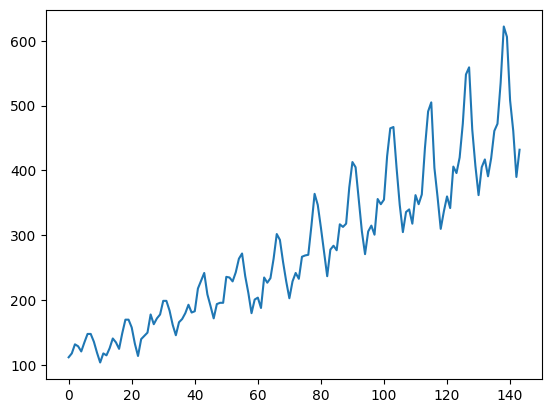

In [4]:
plt.plot(ap)
plt.show()

Log Transformation 통해 variance 조절

In [5]:
ap_transformed = np.log(ap)
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


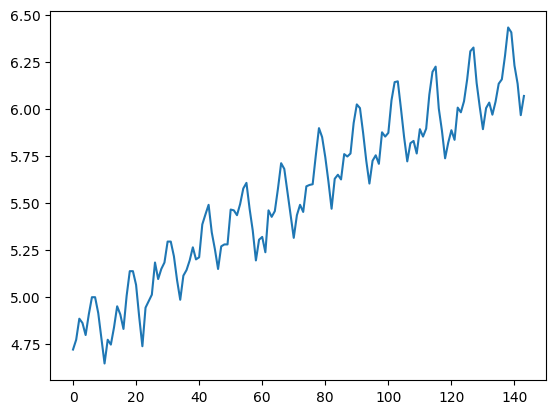

In [6]:
plt.plot(ap_transformed)
plt.show()

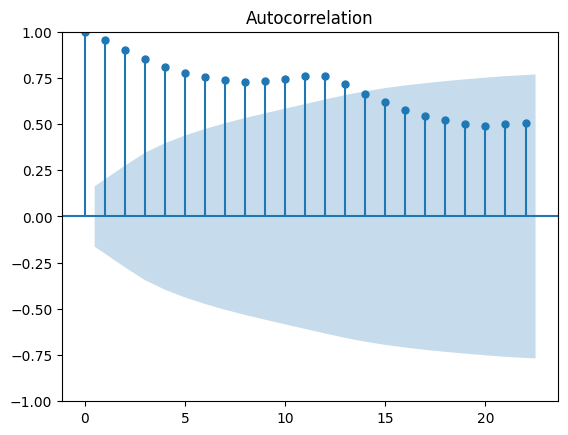

In [7]:
plot_acf(ap_transformed)        # acf plot, 점차 감소하는 모양
plt.show()

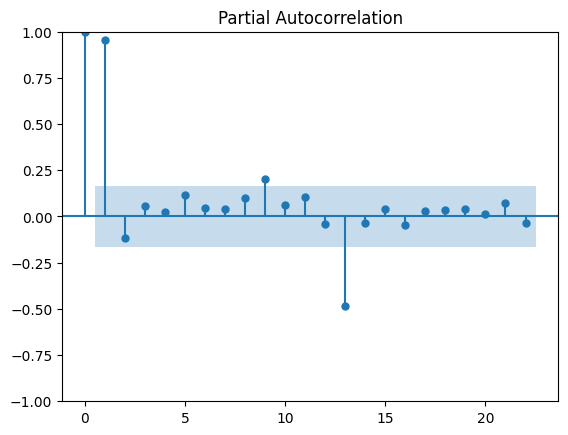

In [8]:
plot_pacf(ap_transformed)       # pacf plot, lag 2까지 유의미한 모양
plt.show()

추세가 남아 있어 위와 같은 그래프가 출력 > 추세 제거

In [9]:
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()
ap_diff

,#Passengers
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
5,0.109484
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


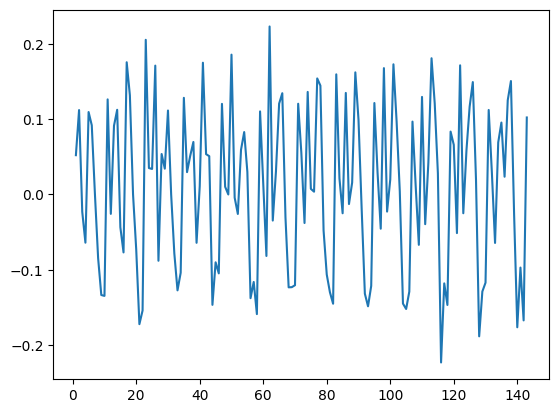

In [10]:
plt.plot(ap_diff)
plt.show()

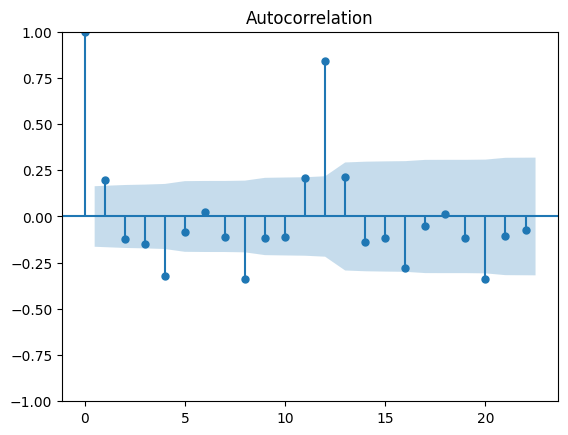

In [11]:
plot_acf(ap_diff)       # lag 1과 lag 12에서 유의미한 lag 포착
plt.show()

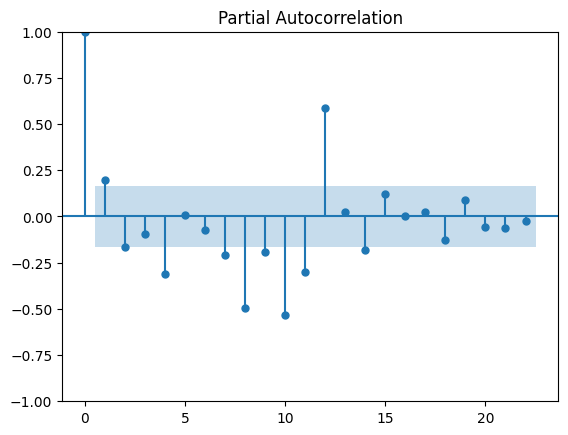

In [12]:
plot_pacf(ap_diff)      # lag 1, lag 8 - 12 쯤에서 유의미한 lag 포착
plt.show()

# acf, pacf 에서 n = 12 쯤 유의미한 상관관계가 나타나는데, 이는 계절성 성분으로 보임.
# auto ARIMA 적합 시 계절성 고려

In [13]:
# test, train set 분리

train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed[train_size:]       # 시간 순서 유지

In [ ]:
# autoARIMA 모델
model = pm.AutoARIMA(seasonal=True, suppress_warnings=True, trace=True, m=12)
res = model.fit(ap_transformed_train)   


# seasonal = True 인 경우, ARIMA(p,d,q)에 (P,D,Q)m가 추가된 SARIMA 모델이 됨
# P, D, Q 는 각각 계절 AR 차수, 계절 차분 횟수, 계절 MA 차수가 되며 m 은 계절 주기가 됨(위와 같은 월별 데이터 연간 주기는 m = 12)


# node
# model = pm.AutoARIMA(seasonal=True, suppress_warnings=True, trace=True, max_D=12, D=12) 
# ARIMA(1,1,4)(0,0,0)[0]    > 계절성 반영 X

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-370.806, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-375.769, Time=0.63 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-348.802, Time=0.26 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-373.727, Time=1.23 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-367.471, Time=0.65 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-371.834, Time=1.25 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-376.915, Time=0.41 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-348.813, Time=0.16 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-372.659, Time=0.65 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-374.920, Time=1.10 sec
 ARIMA(1,0,2)(1,1,0

In [15]:
preds, conf_int = res.predict(n_periods = ap_transformed_test.shape[0], return_conf_int=True)
# confidence interval까지 도출

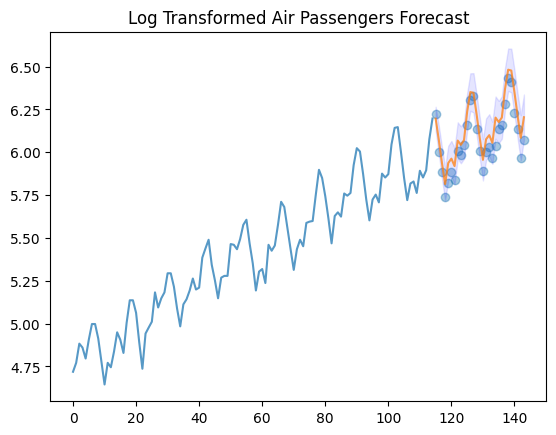

In [16]:
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0])

plt.plot(x_axis[:ap_transformed_train.shape[0]], 
         ap_transformed_train, 
         alpha = 0.75
         )
plt.plot(x_axis[ap_transformed_train.shape[0]:], 
         preds, 
         alpha = 0.75
         )
plt.scatter(x_axis[ap_transformed_train.shape[0]:], 
            ap_transformed_test, 
            alpha = 0.4, 
            marker = 'o'
            )
plt.fill_between(x_axis[-preds.shape[0]:], 
                 conf_int[:,0], 
                 conf_int[:,1], 
                 alpha = 0.1, 
                 color = 'b'
                 )
plt.title('Log Transformed Air Passengers Forecast')
plt.show()

ARCH 모델 실습

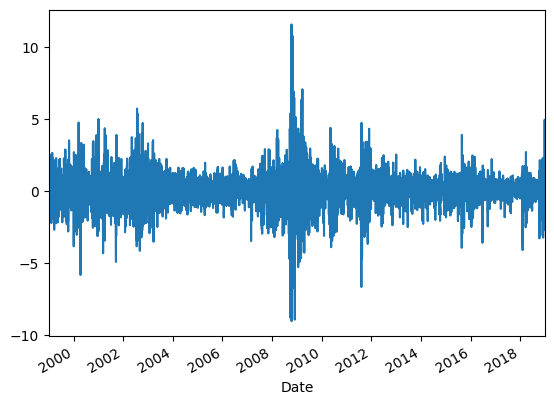

In [ ]:
import datetime as dt
import arch.data.sp500

st = dt.datetime(2002, 1, 1)    # start date
en = dt.datetime(2022, 1, 1)    # end date
data = arch.data.sp500.load()   # s&p 500 data
market = data['Adj Close']      # 종가 활용
returns = 100 * market.pct_change().dropna()    # 수익률로 변환
ax = returns.plot()         
xlim = ax.set_xlim(returns.index.min(), returns.index.max())
plt.show()

In [ ]:
# Conditional Heteroskedasticity(조건부 이분산성) 나타남

from arch import arch_model

am = arch_model(returns)
res = am.fit(update_freq = 5)   # update_freq: 로그 출력 주기
print(res.summary())

# summary의 Volatility Model 중 alpha[1], beta[1]은 GARCH(1,1)을 의미
# alpha: ARCH 효과(과거 오차 제곱항 영향) - 단기 충격에 대한 민감도
# beta: GARCH 효과(과거 분산의 영향) - 장기적 충격 지속성 > 상당히 지속적인 충격이 있음을 시사 
# alpha + beta > 1에 매우 가까움 > 변동성이 한 번 커지면 오래 지속되는 경향

# GARCH: 분산이 과거 충격과 변동성에 의해 결정되는 모형

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.282172935112
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477483926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476989014
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Thu, Sep 11 2025   Df Residuals:                     5029
Time:          

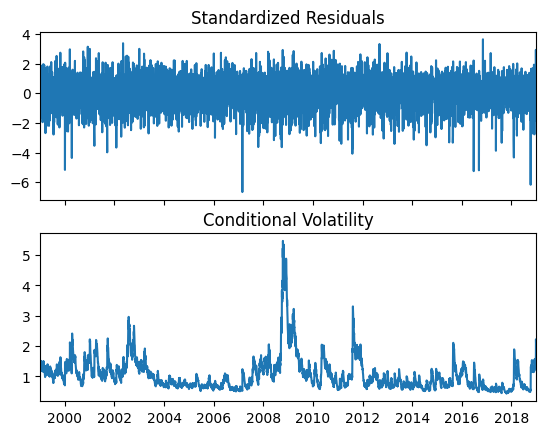

In [ ]:
res.plot()
plt.show()

# 적절히 퍼져있는 잔차 확인 가능
# 2008년 금융 위기 당시 분산이 크게 상승한 것을 확인 가능